**Group Details:**

- Name: ID: Omri Rahimpur
- Name: ID:
- Name: ID:

In [1]:
#@title Helper Functions and Imports

from pydrive2.auth import GoogleAuth
from google.colab import drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Some visual settings
sns.set()
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14

RENT_ID = '1R6v2uHpFyNb1z2DT0M_JHTUE3PHFFYmu'
SOCIORANK_ID = '1gc57mT5zgIb-XeVsMfCphnWTRz1-dmLj'

def load_df(drive_id, **load_kwargs):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  download = drive.CreateFile({'id': drive_id})
  filename = '{}.csv'.format(drive_id)
  download.GetContentFile(filename)
  return pd.read_csv(filename, **load_kwargs)

# Introduction to Data Science - Lab \#2

## Exploratory Data Analysis

### Case Study: Rental Listings in Jerusalem
In this lab we will practice our exploratory data analysis skills using real data!

We will explore data of rental pricings in Jersualem.
The dataset consists of listings published in https://www.komo.co.il/ during the summer of 2022.

We will use two python packages for visualizing the data: `matplotlib` (and specifically its submodule `pyplot` imported here as `plt`) and `seaborn` (imported as `sns`). Seaborn is a package that "wraps" matplotlib and introduces more convenient functions for quickly creating standard visualizations based on dataframes.

Please **breifly** go over this [quick start guide](https://matplotlib.org/stable/tutorials/introductory/quick_start.html) to matplotlib, the [first](https://seaborn.pydata.org/tutorial/introduction.html) seaborn introduction page until the "Multivariate views on complex datasets" section (not included), and the [second](https://seaborn.pydata.org/tutorial/function_overview.html) introduction page until the "Combining multiple views on the data" section.



In [2]:
#@title Loading the dataset
rent_df = load_df(RENT_ID)[['propertyID','neighborhood','monthlyRate','mefarsem','rooms','floor','area','entry','description','numFloors']]
rent_df = rent_df.drop_duplicates(subset='propertyID').reset_index(drop=True)
rent_df_backup_for_exercise = rent_df.copy()
clean_df_area_filtered = None
clean_df = None

Let's print a random sample:

In [3]:
np.random.seed(2)
rent_df.sample(5)

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
403,3981729,גבעת מרדכי,4500.0,private,3.0,6.0,62.0,10/08/2022,"דירה יפה, נקיה, ומשופצת לאחרונה. מתאים למשפחות...",8.0
457,3991612,קריית משה,3000.0,private,3.5,3.0,NaN,NaN,במחיר חסר תקדים! דירה בת 3.5 חדרים. ברחוב שושנ...,4.0
500,3976987,הגבעה הצרפתית,7800.0,private,4.0,11.0,118.0,10/08/2022,"בבניין שתי מעליות, מעלית שבת. חניון תת קרקעי ע...",13.0
84,3985356,גילה,3600.0,private,2.0,1.0,60.0,10/08/2022,"מקום מדהים ,קומה ראשונה,תחנת אוטובוס,גני ילדים...",1.0
109,3994714,קריית יובל,3500.0,private,2.0,1.0,55.0,10/08/2022,"להשכרה דירת 3 חדרים שהפכו אותה ל2 חדרים, עם סל...",4.0


And print some summary statistics:

In [4]:
rent_df.describe(include='all')

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
count,6.120000e+02,612,612.000000,612,612.000000,611.000000,295.000000,292,596,610.000000
unique,NaN,54,NaN,2,NaN,NaN,NaN,17,578,NaN
top,NaN,קריית יובל,NaN,private,NaN,NaN,NaN,10/08/2022,"להשכרה, דירה, קומה ראשונה, בירושלים",NaN
freq,NaN,66,NaN,600,NaN,NaN,NaN,259,8,NaN
mean,3.981582e+06,NaN,4717.393791,NaN,2.927288,1.916530,87.664407,NaN,NaN,3.908197
std,6.525543e+04,NaN,2195.215139,NaN,1.007350,1.581006,277.004591,NaN,NaN,1.978065
min,2.494041e+06,NaN,0.000000,NaN,1.000000,-2.000000,1.000000,NaN,NaN,1.000000
25%,3.981694e+06,NaN,3500.000000,NaN,2.000000,1.000000,42.000000,NaN,NaN,3.000000
50%,3.987901e+06,NaN,4400.000000,NaN,3.000000,2.000000,60.000000,NaN,NaN,4.000000
75%,3.992605e+06,NaN,5800.000000,NaN,3.500000,3.000000,85.000000,NaN,NaN,4.000000


The variables we will focus on are:
1. neighborhood: The hebrew name of the neighborhood in jerusalem where the listing is located
2. monthlyRate: The monthly rate (שכר דירה) in shekels
3. rooms: The number of rooms in the apartment
4. floor: The floor in which the apartment is located
5. area: The area of the apartment in squared meters
6. numFloors: The total number of floors in the building

**What is the distribution of prices in this dataset?**

Q: Plot a histogram with 30 bins of the monthly rates in this dataset:

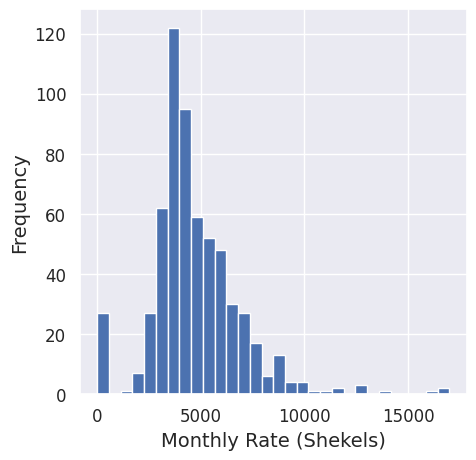

In [5]:
rent_df['monthlyRate'].hist(bins=30, figsize=(5,5))
plt.xlabel("Monthly Rate (Shekels)")
plt.ylabel("Frequency")
plt.show()

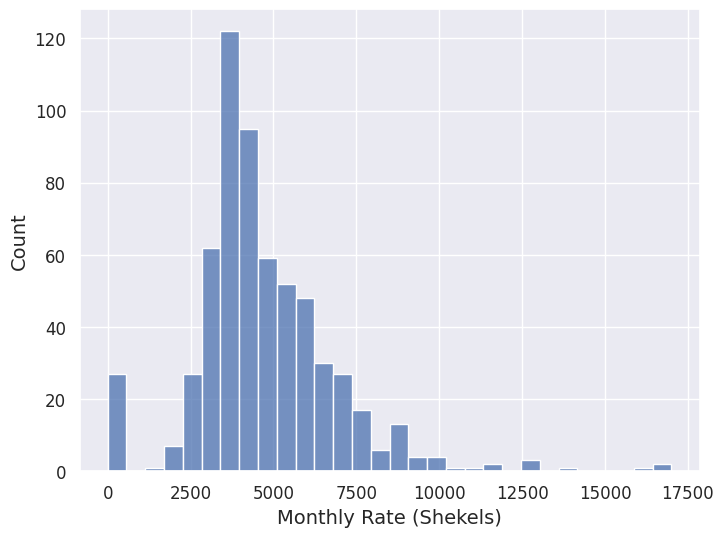

In [6]:
# @title Solution 1
plt.figure(figsize=(8,6))
sns.histplot(rent_df['monthlyRate'], bins=30)
plt.xlabel("Monthly Rate (Shekels)");

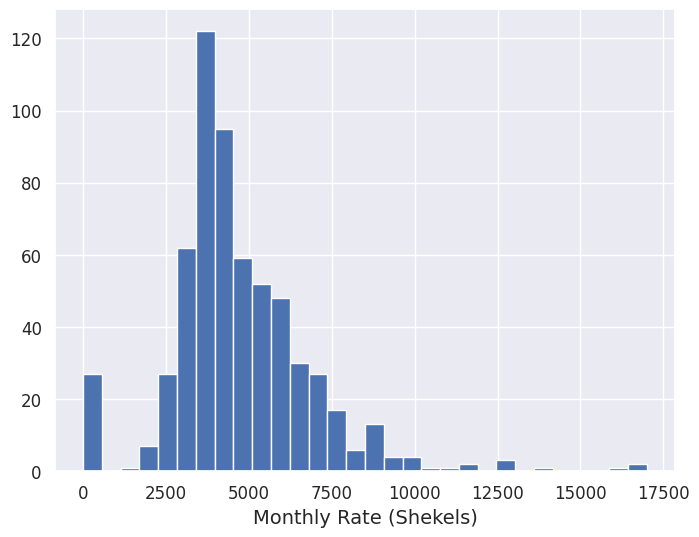

In [7]:
# @title Solution 2
rent_df["monthlyRate"].hist(bins=30, figsize=(8,6))
plt.xlabel("Monthly Rate (Shekels)");


<br><br><br><br><br><br><br>
We see that the prices distribution peaks around ~3500 Shekels and that it is right skewed, as there are some very expensive apartments.
We can also see a peak at zero which makes sense as sometimes listings do not include a price. We would want to filter those out when we analyze prices later on.

Q: Print the number of listings that have no monthly rate:


In [8]:
# @title Solution
print("Number of apartments without a price: ", rent_df['monthlyRate'].value_counts()[0].round(3))

Number of apartments without a price:  25


We want to remove those listings, but we don't want to lose these entries, as we might want to know how many and what type of outliers we originally removed. So we create another dataframe that has the listings we removed and the reason for removal.

In [9]:
outlier_df = pd.DataFrame(columns=rent_df.columns.to_list()+['reason']) # will save the outliers

outliers = rent_df[rent_df['monthlyRate'] <= 0].reset_index(drop=True)
outliers['reason']= "monthlyRate <= 0"
outlier_df = pd.concat([outlier_df, outliers], axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)
outlier_df.tail()

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors,reason
20,3983978,קריית משה,0.0,private,4.0,3.0,100.0,10/08/2022,דירת 4 חדרים - במצב מצויין - שמורה ביותר כולל ...,5.0,monthlyRate <= 0
21,3985184,נווה יעקב,0.0,private,4.0,1.0,68.0,10/08/2022,"דירה במצב שמור מאד. ממוזגת, 2 חדרי שירותים (אח...",2.0,monthlyRate <= 0
22,3952750,מוסררה,0.0,private,5.5,1.0,180.0,10/08/2022,"להשכרה דירה מפוארת, במרכז העיר מרחק הליכה מהע...",4.0,monthlyRate <= 0
23,3988157,גבעת שאול,0.0,private,5.0,1.0,140.0,10/08/2022,בית פרטי שתי קומות שימש בעבר לגן מתאים כל מתרה...,2.0,monthlyRate <= 0
24,3981160,גבעת משואה,0.0,private,6.0,-2.0,NaN,NaN,"מול נוף עוצר נשימה, 6 חדרים מרווחים, מרפסת 70 ...",5.0,monthlyRate <= 0


We will now remove those listings and save the result to a new variable `clean_df`:

In [10]:
clean_df = rent_df[rent_df['monthlyRate'] > 0].reset_index(drop=True)

**What is the distribution of the number of rooms?**

Q: Use `sns.countplot` to compare the counts of listings with different numbers of rooms. Plot all bars in the same [color](https://matplotlib.org/stable/tutorials/colors/colors.html) of your choice.


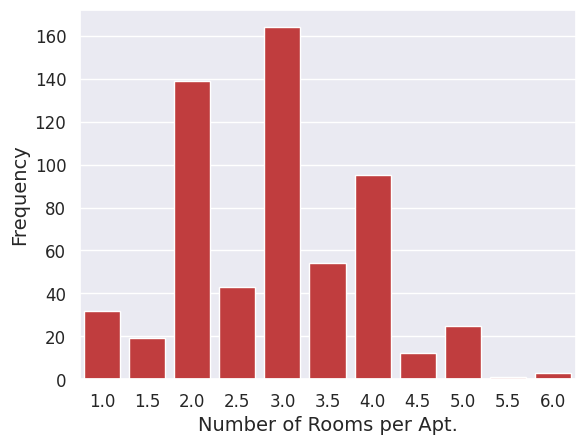

In [11]:
sns.countplot(data=clean_df, color='tab:red', x='rooms')
plt.xlabel("Number of Rooms per Apt.")
plt.ylabel("Frequency")
plt.show()

the most common number of rooms in a given apt. is 3, with a bit more than 160 apt having that amount of rooms. also common is 2 rooms with 140 apt, and 4 rooms with around 90 apt. half rooms are less common.

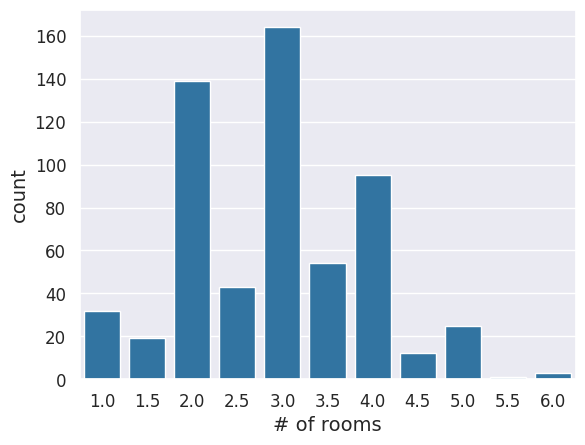

In [12]:
# @title Solution
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
else:
  sns.countplot(x='rooms', data=clean_df, color='tab:blue')
  plt.xlabel("# of rooms");

The distribution peaks at three rooms and we also see that "half rooms" are less common.

**Can we see an association between apartment area and price?**

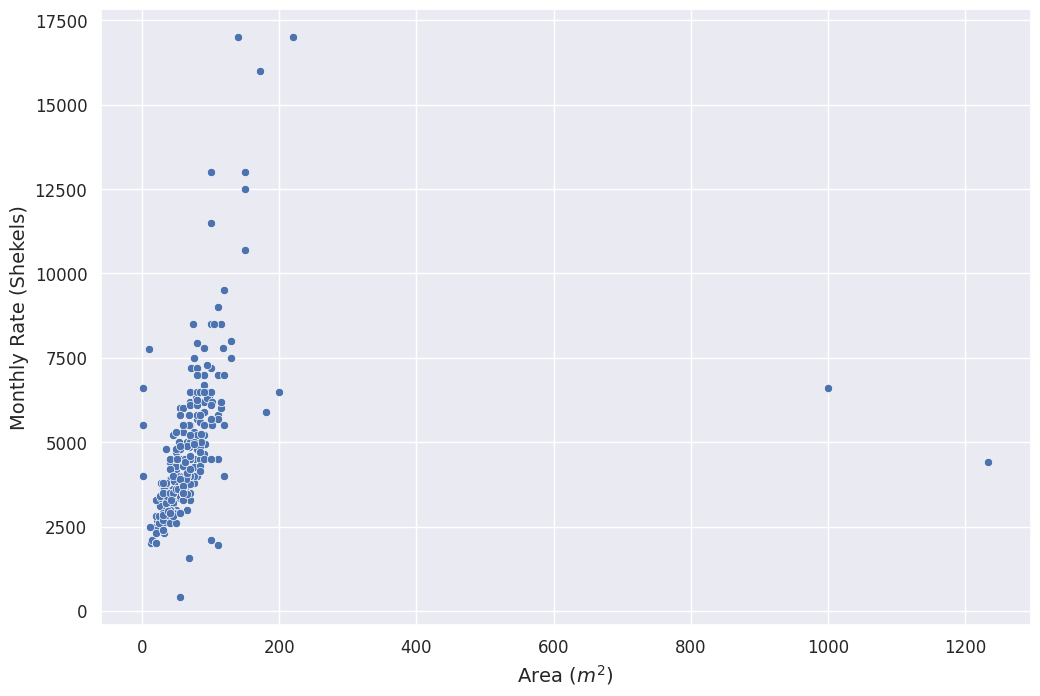

In [13]:
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
else:
  plt.figure(figsize=(12,8))
  sns.scatterplot(x='area', y='monthlyRate', data=clean_df)
  plt.ylabel("Monthly Rate (Shekels)")
  plt.xlabel("Area ($m^2$)");

We see clear outliers here! We know that area is measured in squared meters and it is unlikely that there are any apartments of ~1000$m^2$.

Let's look at those samples to see if we can understand what happend there:

In [14]:
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
else:
  display(clean_df.sort_values('area', ascending=False).head(4))

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
185,3964340,תלפיות,4400.0,private,2.0,2.0,1234.0,10/08/2022,NaN,3.0
543,3956561,זכרון משה,6600.0,private,3.5,3.0,1000.0,01/07/2022,דירה מהממת בלב ירושלים. צמודה לרכבת הקלה- תחנת...,3.0
576,3974914,תלפיות,17000.0,private,5.0,3.0,220.0,10/08/2022,"דירת 5 חדרים ענקית ומהממת, בבנין בוטיק ויחודי ...",4.0
566,3988577,פסגת זאב,6500.0,private,5.5,1.0,200.0,10/08/2022,"דירה בת 5.5 חדרים . בקומה התחתונה סלון , מטבח ...",3.0


And inspect the description of one of those listings:

In [15]:
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
else:
  display(clean_df.at[543,'description'])

'דירה מהממת בלב ירושלים. צמודה לרכבת הקלה- תחנת הדוידקה. 3 חדרים ענקיים ולכל חדר מרפסת גדולה. חלל כניסה עם פינת ישיבה. מתאימה מאוד ל- 3 שותפים'

Clearly not a 1000 m^2 apartment...

Q: Save a new dataframe named `clean_df_area_filtered` with all listings with area smaller than 800 m^2. Again, add the removed outliers to the outliers_df dataframe.

Plot again the scatter of area vs. monthly rate after removing the outliers.

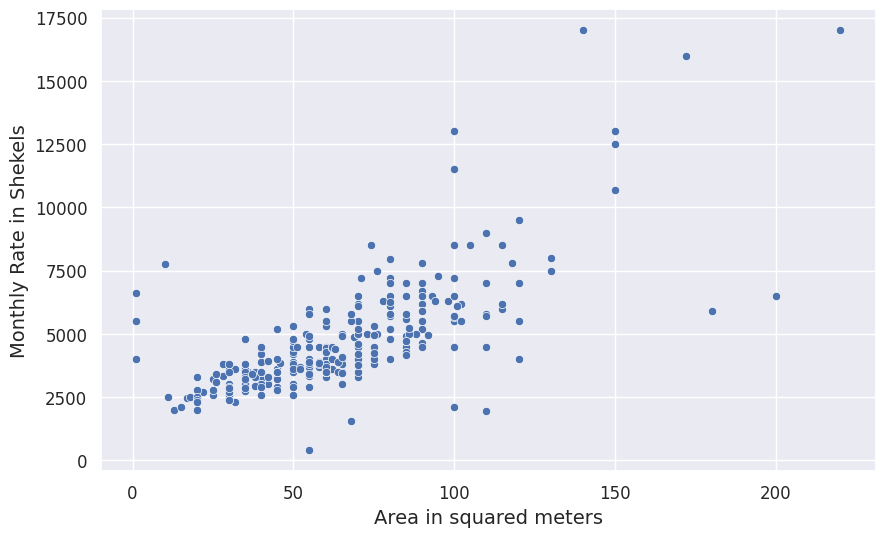

In [16]:
# save outliers
outliers = clean_df[clean_df['area'] >= 800].reset_index(drop=True)
outliers['reason']= "'area' >= 800"
outlier_df = pd.concat([outlier_df, outliers], axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)

# remove the outliers from the dataset
clean_df_filteredByArea = clean_df[clean_df['area'] < 800].reset_index(drop=True)

# plotting as asked
plt.figure(figsize=(10,6))
sns.scatterplot(x='area',y='monthlyRate', data=clean_df_filteredByArea)
plt.xlabel("Area in squared meters")
plt.ylabel("Monthly Rate in Shekels")
plt.show()

How can it be that Apt with  $m^2=0$ (almost) are with positive monthly rate for rent?! probably, they are with missing info (not even truly needed to by looked for in the description)

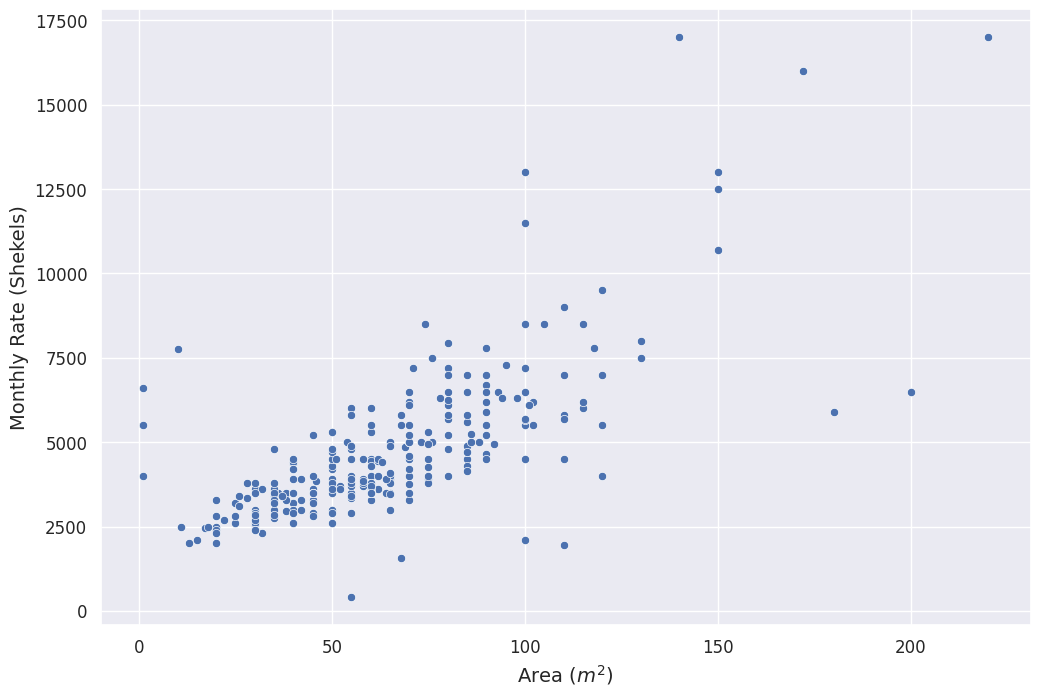

In [17]:
# @title Solution
if clean_df is None:
  print("Can't run until 'clean_df' is created!")
elif outlier_df is None:
  print("Can't run until 'outlier_df' is created!")
else:
  # save outliers
  outliers = clean_df[clean_df['area'] >= 800].reset_index(drop=True)
  outliers['reason']= "'area' >= 800"
  outlier_df = pd.concat([outlier_df, outliers], axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)

  # remove the outliers from the dataset
  clean_df_area_filtered = clean_df[clean_df['area'] < 800].reset_index(drop=True)
  plt.figure(figsize=(12,8))
  sns.scatterplot(x='area', y='monthlyRate', data=clean_df_area_filtered)
  plt.xlabel("Area ($m^2$)")
  plt.ylabel("Monthly Rate (Shekels)");

Again, we see some strange behavior of apartments with almost zero area but with a high monthly rate. Let's check them out:

We start with all apartments with an area between 0 to 25 $m^2$:

In [18]:
# Show all apartments with area between 0 and 25
clean_df_area_filtered[clean_df_area_filtered['area'].between(0,25)]

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
0,3994505,קריית יובל,2000.0,private,1.0,2.0,13.0,10/08/2022,"יחידת דיור להשכרה ברחוב הראשי של קריית יובל, ה...",2.0
1,3981298,רחביה,2450.0,private,1.0,1.0,17.0,10/08/2022,דירת יחיד 17 מטר כולל מרפסת קטנה,3.0
3,3993997,בית וגן,2100.0,private,1.0,0.0,15.0,10/08/2022,"דירת חדר, כ-15 מ""ר, במיקום מרכזי אך שקט, משופצ...",3.0
5,3993552,הר נוף,2000.0,private,1.0,0.0,20.0,10/08/2022,"יחידה משופצת ליחיד או למשרד , מיקום מצוין",4.0
6,3972039,גבעת שאול,2700.0,private,1.0,0.0,22.0,10/08/2022,"דירת חדר כחדשה , כניסה נפרדת ללא וועד בית , מו...",1.0
7,3988096,המושבה הגרמנית,2500.0,private,1.0,0.0,18.0,10/08/2022,רלוונטי לנשים בלבד. ללא עישון. ללא חיות מחמד. ...,1.0
8,3992809,נחלאות,3200.0,private,1.0,2.0,25.0,10/08/2022,"הדירה המגניבה בנחלאות, מתפנה אחרי תקופה ארוכה ...",2.0
10,3983516,הגבעה הצרפתית,2000.0,private,1.0,2.0,20.0,10/08/2022,"דירת חדר קטנה, מסוגננת ונחמדה, מתאימה ליחיד בל...",13.0
12,3987706,נחלאות,2800.0,private,1.0,0.0,20.0,10/08/2022,"להשכרה, דירה, בירושלים ברחוב חצור בנחלאות. דיר...",2.0
13,3991842,קטמון הישנה,2500.0,private,1.0,1.0,20.0,10/08/2022,דירת חדר ליחיד באזור יפייפה ושקט בקטמון הישנה....,4.0


Some make sense and others do not. Let's focus on the expensive ones (between 5,000 and 10,000 shekels):

In [19]:
# Show all apartments with area between 0 and 25 that also have a price between 5000 and 10000
if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
else:
  display(clean_df_area_filtered[clean_df_area_filtered['area'].between(0,25) & clean_df_area_filtered['monthlyRate'].between(5000, 10000)])

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors
197,3984483,ארנונה,6600.0,private,4.0,2.0,1.0,01/09/2022,"בשכונת ארנונה, רח’ שלום יהודה, דירת 4 חדרים מש...",4.0
234,3985019,פסגת זאב,5500.0,private,4.0,3.0,1.0,10/08/2022,להשכרה 4 חדרים מרווחת עם מרפסת סוכה שטופת שמש ...,4.0
235,3944204,בית הכרם,7750.0,private,4.0,3.0,10.0,01/09/2022,"בבניין חדש, מושקעת, מוארת, מאווררת רח’ שקט, רח...",5.0
274,3982178,נווה יעקב,5500.0,private,5.0,1.0,1.0,10/08/2022,"דירה במצב מעולה!! נוף, מוארת, מאווררת, מרפסת סוכה",4.0


Those are clearly wrong too...
Besides that the relationship between the area and the price seems linear.
Let's remove these outliers too:



In [20]:
#remove the outliers
if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
elif outlier_df is None:
  print("Can't run until 'outlier_df' is created!")
else:
  non_ouliers = clean_df_area_filtered['area'] > 10 # get non outliers series of true/false

  # save outliers
  outliers = clean_df_area_filtered[~non_ouliers].reset_index(drop=True) # get the outliers
  outliers['reason']= "'area' <= 10"
  outlier_df = pd.concat([outlier_df, outliers], axis=0, ignore_index=True).drop_duplicates().reset_index(drop=True)

  # remove them
  clean_df_area_filtered = clean_df_area_filtered[non_ouliers].reset_index(drop=True)

#### **Can we see a different pattern for top floor apartments?**
Q: Plot again a scatter of area vs. monthly rate. This time distinguish (by color / marker style or both) between apartments that are in the top floor and the rest of the apartments. (To do that you should create a new column in `clean_df_area_filtered` called `is top floor` and set it to 1 if the apartment is in the top floor and 0 otherwise.)

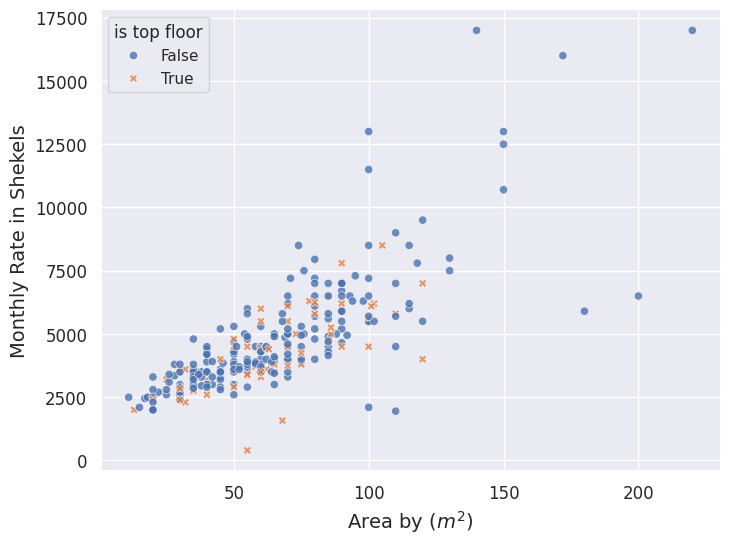

In [21]:
clean_df_area_filtered['is top floor'] = clean_df_area_filtered['floor'] == clean_df_area_filtered['numFloors'] # distinguishing between top floors and none top floors
plt.figure(figsize=(8,6)) # size of plot
sns.scatterplot(x='area', y='monthlyRate', data=clean_df_area_filtered, alpha=0.8, hue='is top floor', style="is top floor") #hist that distingushes between top floor and not top floor
plt.xlabel("Area by ($m^2$) ") # naming x axis
plt.ylabel("Monthly Rate in Shekels") #naming y axis
plt.show()

I see weak negative correlation between monthly rates and being top floor. top floor is disadvantages at some cases, and is not is others. one can take into considiration: relations between location and top floor, and the way tose correlate with having/not having an elevator.

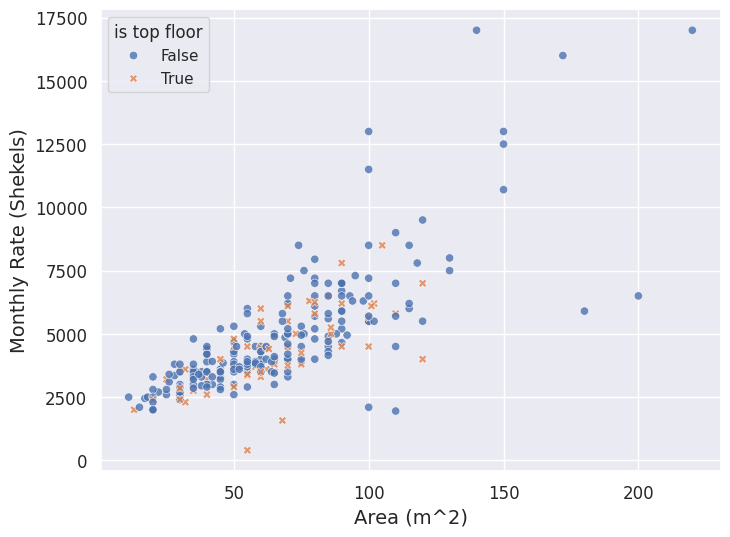

In [22]:
# @title Solution

if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
else:
  clean_df_area_filtered['is top floor'] = clean_df_area_filtered['floor'] == clean_df_area_filtered['numFloors']
  plt.figure(figsize=(8,6))
  sns.scatterplot(x='area', y='monthlyRate', data=clean_df_area_filtered, alpha=0.8, hue='is top floor', style="is top floor");
  plt.xlabel("Area (m^2)")
  plt.ylabel("Monthly Rate (Shekels)");

We can take a deeper look on the apartments with the very high monthly rate (to see if those are outliers or not):

In [23]:
if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
else:
  display(clean_df_area_filtered[clean_df_area_filtered['monthlyRate'] > 11000])

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors,is top floor
198,3956418,רחביה,13000.0,agent,4.0,1.0,100.0,NaN,Beautifully renovated furnished authentic arab...,3.0,False
236,3985051,טלביה,17000.0,private,4.0,4.0,140.0,10/08/2022,בקינג דיוד רזדנס דירת 4 חדרים להשכרה ללא תיו...,10.0,False
257,3982363,רחביה,16000.0,private,5.0,2.0,172.0,10/08/2022,"הזדמנות נדירה!!! ברחוב רד""ק, בנקודה הכי קרובה ...",5.0,False
260,3980016,אבו תור,12500.0,private,5.0,0.0,150.0,10/08/2022,"דירת דופלקס ענקית 150 מ""ר עם כניסה נפרדת. הדיר...",4.0,False
263,3994228,בית ישראל,11500.0,private,5.0,1.0,100.0,10/08/2022,"דירה ממוקמת בלב ירושלים שכונת בית ישראל, מרפסת...",3.0,False
266,3974914,תלפיות,17000.0,private,5.0,3.0,220.0,10/08/2022,"דירת 5 חדרים ענקית ומהממת, בבנין בוטיק ויחודי ...",4.0,False
270,3981999,תלפיות,13000.0,private,5.0,4.0,150.0,10/08/2022,דירת 5 חדרים חדשה! בדירה יש מרפסת מרפסת שירו...,5.0,False


We can see some representation of the more expensive neighborhoods of Jerusalem here.. More on the neighborhoods later on!

**Is there also a relation between the number of rooms and the listing price?**

Q: Create a visualization that compares the distribution of prices for different number of rooms. Your visualization should provide information about central tendency (mean/median/mode) and some information about the distribution of individual values around it (standard deviation/interquartile range) for each number of rooms. Also, show the real prices of the listings per number of rooms.

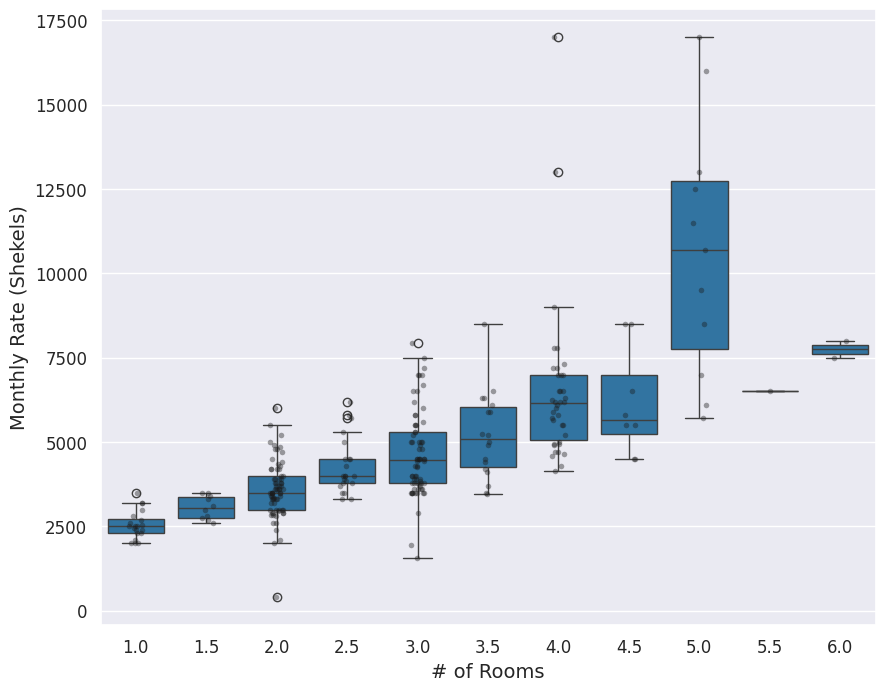

In [24]:
# @title Solution
if clean_df_area_filtered is None:
  print("Can't run until 'clean_df_area_filtered' is created!")
else:
  plt.figure(figsize=(10,8))
  sns.boxplot(x='rooms', y='monthlyRate', data=clean_df_area_filtered, color='tab:blue')
  sns.stripplot(x='rooms', y='monthlyRate', alpha=0.4 ,size=4,color='k',data=clean_df_area_filtered)
  plt.xlabel("# of Rooms")
  plt.ylabel("Monthly Rate (Shekels)");

  # Or:
  # plt.figure(figsize=(10,8))
  # sns.barplot(x='rooms', y='monthlyRate', data=clean_df_area_filtered, color='tab:blue', errorbar=None, estimator='median')
  # # Can also use mean but median is more informative in this case as prices are skewed...
  # sns.stripplot(x='rooms', y='monthlyRate', alpha=0.4 ,color='k',data=clean_df_area_filtered)
  # plt.xlabel("# of Rooms")
  # plt.ylabel("Monthly Rate (Shekels)");

  #Violin plot completly fails for very small subsets:
  # plt.figure(figsize=(10,8))
  # sns.violinplot(x='rooms', y='monthlyRate', data=clean_df_area_filtered, color='tab:blue')
  # plt.xlabel("# of Rooms")
  # plt.ylabel("Monthly Rate (Shekels)");


Now that we finished pre-processing the data, we can see the state of our outliers VS the data that remains:

In [25]:
if outlier_df is None:
  print("Can't run until 'outlier_df' is created!")
else:
  # describe the outlier data
  display(outlier_df.groupby('reason').describe())
  print(f"Proportion removed: {100*len(outlier_df) / (len(outlier_df)+len(clean_df_area_filtered)):.0f} %")

monthlyRate                                               \
                       count    mean          std     min     25%     50%   
reason                                                                      
'area' <= 10             5.0  5870.0  1399.821417  4000.0  5500.0  5500.0   
'area' >= 800            2.0  5500.0  1555.634919  4400.0  4950.0  5500.0   
monthlyRate <= 0        25.0     0.0     0.000000     0.0     0.0     0.0   

                                 rooms        ...    area         numFloors  \
                     75%     max count  mean  ...     75%     max     count   
reason                                        ...                             
'area' <= 10      6600.0  7750.0   5.0  3.90  ...     1.0    10.0       5.0   
'area' >= 800     6050.0  6600.0   2.0  2.75  ...  1175.5  1234.0       2.0   
monthlyRate <= 0     0.0     0.0  25.0  3.28  ...    99.0  4554.0      25.0   

                                                            
                  mean       std  min  25%  50%  75%   max  
reason                                                      
'area' <= 10      3.80  1.095445  2.0  4.0  4.0  4.0   5.0  
'area' >= 800     3.00  0.000000  3.0  3.0  3.0  3.0   3.0  
monthlyRate <= 0  3.48  2.293469  1.0  2.0  3.0  4.0  11.0  

[3 rows x 40 columns]

Proportion removed: 10 %


# Submission Exercises

## Part 1: Diving deeper into rental prices

We will create a copy of the dataset and work on that. We want to make sure that we do not modify the original dataset.

In [26]:
# @title Part 1 - Create a DataFrame
part1_df = rent_df_backup_for_exercise.copy()

Let's go back to the distribution of monthly rental prices in the dataset. Are there interesting trends in the distribution that we missed in the visualizations before?

**Use only `part1_df` for the coding questions in this part**



### **Question 1**
Plot 3 different histograms of the monthly prices with 20, 60 and 120 bins respectively, each in a different axis/figure.


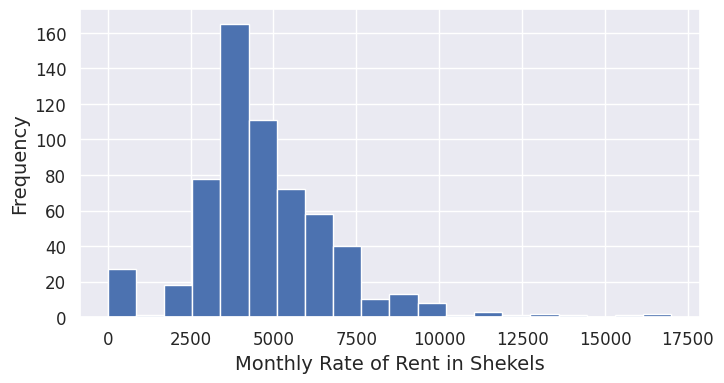

In [27]:
# plotting for 20 bins
part1_df['monthlyRate'].hist(bins=20,figsize=(8,4))
plt.xlabel("Monthly Rate of Rent in Shekels")
plt.ylabel("Frequency")
plt.show()

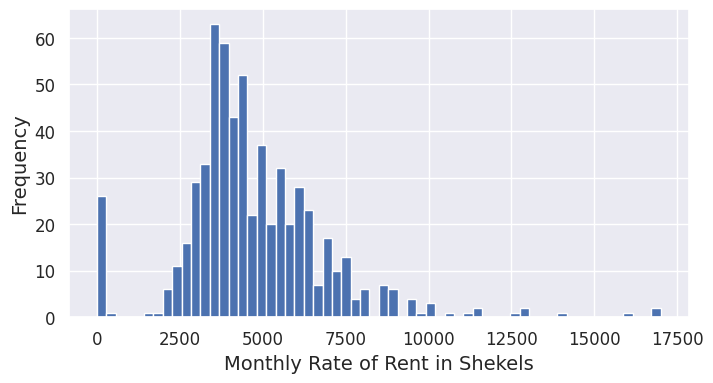

In [28]:
# plotting for 60 bins
part1_df['monthlyRate'].hist(bins=60,figsize=(8,4))
plt.xlabel("Monthly Rate of Rent in Shekels")
plt.ylabel("Frequency")
plt.show()

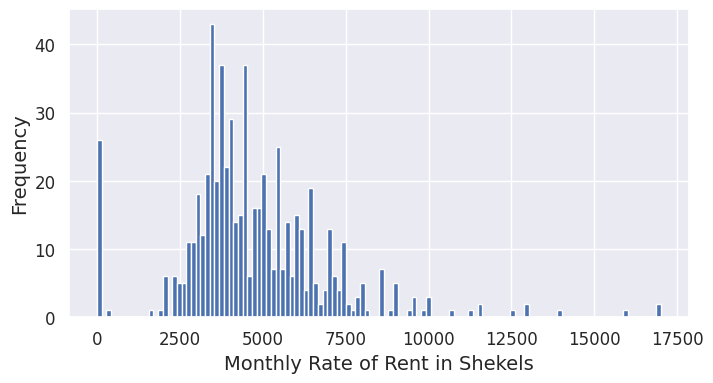

In [29]:
# plotting for 120 bins
part1_df['monthlyRate'].hist(bins=120,figsize=(8,4))
plt.xlabel("Monthly Rate of Rent in Shekels")
plt.ylabel("Frequency")
plt.show()

###**Question 2**
For 60 and 120 bins, you can see a repeating pattern of "peaks" and "vallies" in the distribution (mostly in the range between 500 and 7000). Is this pattern due to people rounding the rental prices? Please create a visualization that answers this question. Describe in words how the graph shows what the answer is (Hint: you can use the '%' operator to compute the remainder of dividing values in a pandas Series by a scalar number).

In [30]:
# @title **extra hint**: please open this cell only after discussing with the course staff the best solution you could come up with

#
# Plot the distribution of values of the 'monthlyRate' column modulu (%) 1000
#

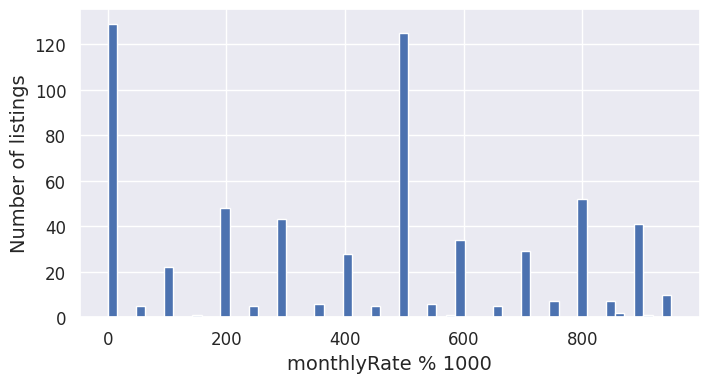

In [31]:
# for 60 bins
part1_df['monthlyRate'].apply(lambda x: x % 1000).hist(bins=60, figsize=(8,4))
plt.xlabel("monthlyRate % 1000")
plt.ylabel("Number of listings")
plt.show()

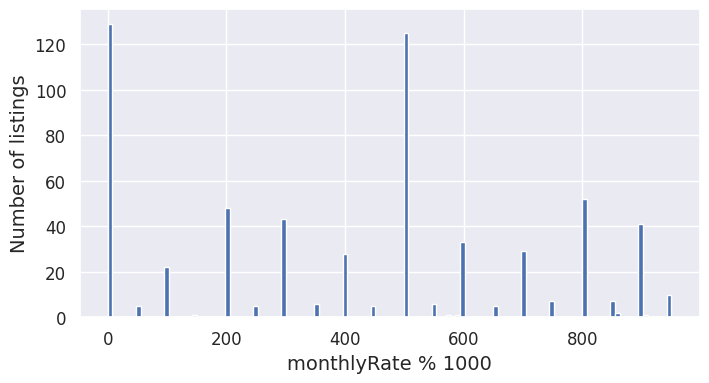

In [32]:
# for 120 bins
part1_df['monthlyRate'].apply(lambda x: x % 1000).hist(bins=120, figsize=(8,4))
plt.xlabel("monthlyRate % 1000")
plt.ylabel("Number of listings")
plt.show()

---
#### Part 1 Question 2 - textual Answer:

we have checked for mudolo 1000 for rent, most 120 apt are left with zero, another 120 with 500. that means that out of the 612 apt. 240 of them have rounded the prices for rent. that means, around 40% of apt in the listing have rounded their prices! that explains the peaks we see at the area of the round prices.

---

###**Question 3**
We expect to see a "drop" in prices frequency near the 5000 Shekels mark due to tax considerations (See [here](https://www.kolzchut.org.il/he/%D7%A4%D7%98%D7%95%D7%A8_%D7%9E%D7%9E%D7%A1_%D7%A2%D7%9C_%D7%94%D7%9B%D7%A0%D7%A1%D7%94_%D7%9E%D7%94%D7%A9%D7%9B%D7%A8%D7%AA_%D7%93%D7%99%D7%A8%D7%94_%D7%9C%D7%9E%D7%92%D7%95%D7%A8%D7%99%D7%9D) for an explanation). Create a histogram visualization of the data with the smallest possible bins such that every bin will include exactly one multiplication of 500 (Hint: read the `bins` parameter documentation and what types it accepts). Explain why does this choice of bin size ensures that we will not see rounding effects. Do you see a "drop" around 5000 Shekels? Are there other "drops"?


In [33]:
max(part1_df['monthlyRate'])
len(list(range(0, 17000, 2000)))

9

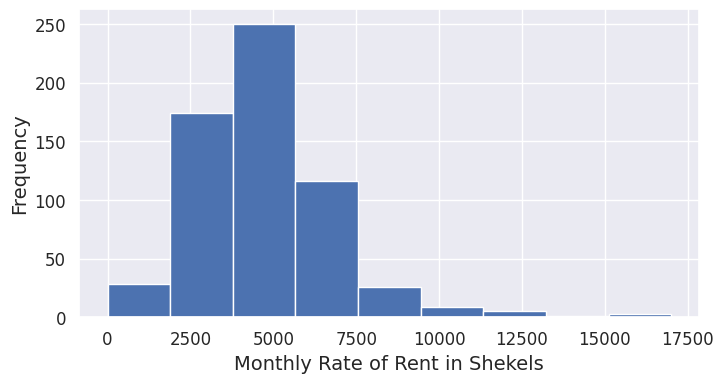

In [34]:
part1_df['monthlyRate'].hist(bins=9,figsize=(8,4))
plt.xlabel("Monthly Rate of Rent in Shekels")
plt.ylabel("Frequency")
plt.show()

---
#### Part 1 Question 3 - textual Answer:

---

I've chosen bins=9. That way, I grouped togather the surroundings of 5ooo (4000-6000). you can see my code above, using the len function to see the desired grouping (number of buns) by 2000.


## Part 2: Size or number of rooms?

In [35]:
# @title Part 2 - Create a DataFrame for Part 2

# Create the dataframe and remove the outliers we found in the intro part:
part2_df = rent_df_backup_for_exercise.copy()
part2_df = part2_df[part2_df['monthlyRate'] > 0].reset_index(drop=True);
part2_df = part2_df[part2_df['area'] < 800].reset_index(drop=True)
part2_df = part2_df[part2_df['area'] > 10].reset_index(drop=True)

We saw that both the number of rooms and the area of an apartment are strongly associated with the monthly rate. We now want to check if those are just two perspectives of the same relation (how big is the apartment) or is there something more to it. We will use the cleaned dataframe for this exercise.

**Use only `part2_df` for the coding questions in this part**


### **Question 1**
Generate a visualization to show that there is a strong association between the number of rooms and the area of the apartment. Explain your choice of plot type and your conclusion from the graph.


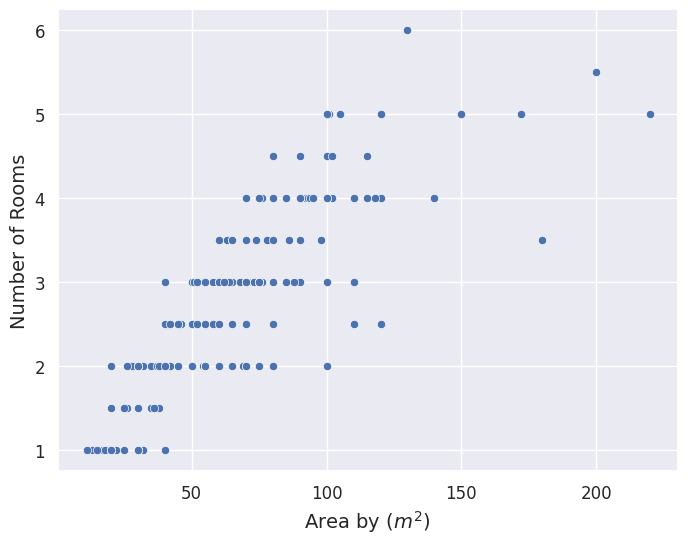

the pearson correation between Area and Rooms is 0.8339753485901139
the spearman correation between Area and Rooms is 0.8699687692779916


In [36]:
plt.figure(figsize=(8,6)) # size of plot
sns.scatterplot(x='area', y='rooms', data=part2_df) #making scatterplot
plt.xlabel("Area by ($m^2$) ") # naming x axis
plt.ylabel("Number of Rooms") #naming y axis
plt.show()
correlation,p_value=pearsonr(part2_df['area'], part2_df['rooms'])
correlation_1,p_value_1=spearmanr(part2_df['area'], part2_df['rooms'])

print("the pearson correation between Area and Rooms is",correlation)
print("the spearman correation between Area and Rooms is",correlation_1)

---
#### Part 2 Question 1 - textual Answer:
*Write your answer here:*

---

I've used scatterplot for I wanted to see the correlation between area and number of rooms, though I was intrested in seeing the connection as a whole, and not solely the linearity of the connection. we do see with our eyes strong positive correlation between the two.
to support this, we've found very strong pearson correlation coefficiant, which indicates strong liniarity, and also very spearman rank, which indicates strong monotonouse connection between the two.

### **Question 2**
Add a new column to the dataframe named `"averageRoomSize"` with the average room size in the given listing.


In [37]:
part2_df['averageRoomSize'] = part2_df['area'] / part2_df['rooms']
part2_df.head(7)

,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors,averageRoomSize
0,3994505,קריית יובל,2000.0,private,1.0,2.0,13.0,10/08/2022,"יחידת דיור להשכרה ברחוב הראשי של קריית יובל, ה...",2.0,13.0
1,3981298,רחביה,2450.0,private,1.0,1.0,17.0,10/08/2022,דירת יחיד 17 מטר כולל מרפסת קטנה,3.0,17.0
2,3981623,מלחה,2550.0,private,1.0,0.0,30.0,10/08/2022,"דירה יפה ומטופחת, לדיירת שקטה לטווח ארוך, ללא ...",2.0,30.0
3,3993997,בית וגן,2100.0,private,1.0,0.0,15.0,10/08/2022,"דירת חדר, כ-15 מ""ר, במיקום מרכזי אך שקט, משופצ...",3.0,15.0
4,3994399,פסגת זאב,2300.0,private,1.0,1.0,32.0,10/08/2022,"בס""ד בפסגת זאב מזרח דירת חדר גדולה משופצת ויפ...",1.0,32.0
5,3993552,הר נוף,2000.0,private,1.0,0.0,20.0,10/08/2022,"יחידה משופצת ליחיד או למשרד , מיקום מצוין",4.0,20.0
6,3972039,גבעת שאול,2700.0,private,1.0,0.0,22.0,10/08/2022,"דירת חדר כחדשה , כניסה נפרדת ללא וועד בית , מו...",1.0,22.0


###**Question 3**
Create a plot of the relation between the average room size and the monthly rate.

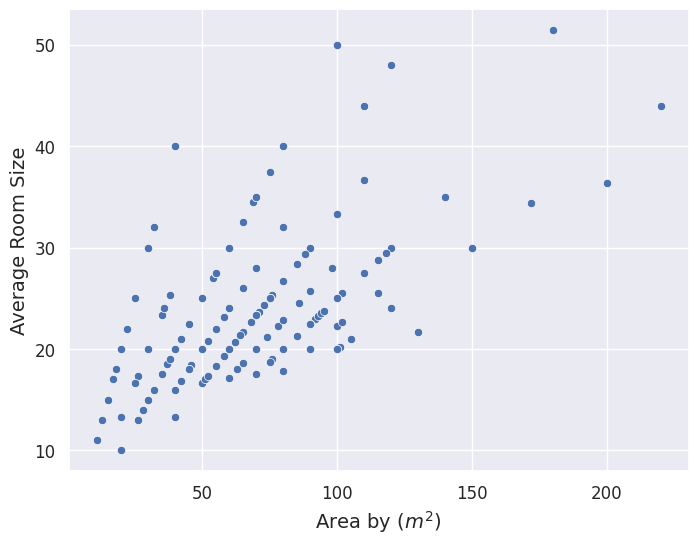

the pearson correation between Area and Average Room Size is 0.5721497475653897
the spearman correation between Area and Average Room Size is 0.5118903315239921


In [38]:
plt.figure(figsize=(8,6)) # size of plot
sns.scatterplot(x='area', y='averageRoomSize', data=part2_df) #making scatterplot
plt.xlabel("Area by ($m^2$) ") # naming x axis
plt.ylabel("Average Room Size") #naming y axis
plt.show()
correlation,p_value=pearsonr(part2_df['area'], part2_df['averageRoomSize'])
correlation_1,p_value_1=spearmanr(part2_df['area'], part2_df['averageRoomSize'])

print("the pearson correation between Area and Average Room Size is",correlation)
print("the spearman correation between Area and Average Room Size is",correlation_1)

### Question 4 - **bonus**
We can see that the variance of the monthly rate increases with the average room size.

Suggest what might be the reason for the increase in the variance and create a visualization to support or refute your suggestion.

In [54]:
part2_df_areaAbove_100= part2_df[part2_df['area'] > 100].reset_index(drop=True)
part2_df_areaAbove_100.head(10)


,propertyID,neighborhood,monthlyRate,mefarsem,rooms,floor,area,entry,description,numFloors,averageRoomSize
0,3991571,פסגת זאב,4000.0,private,2.5,3.0,120.0,10/08/2022,דירת גג עם מרפסת ענקית ונוף פתוח. חדר ענק וסל...,3.0,48.000000
1,3980905,רמת שרת,5800.0,private,2.5,1.0,110.0,10/08/2022,"דירה בבית פרטי, כניסה פרטית, כניסה מיידית. המח...",1.0,44.000000
2,3992073,ארמון הנציב,4500.0,private,3.0,0.0,110.0,10/08/2022,להשכרה דירת 3 חדרים וגינה גדולה. הדירה משופצת!...,4.0,36.666667
3,3982071,הגבעה הצרפתית,7000.0,private,3.0,0.0,110.0,10/08/2022,"דירה ברחוב שקט חנייה בשפע כניסה פרטית , מרפסת...",1.0,36.666667
4,3993668,קריית משה,1950.0,private,3.0,2.0,110.0,10/08/2022,"להשכרה, דירה, קומה 2, בירושלים בקרית משה (קרוב...",5.0,36.666667
5,3982321,טלביה,8500.0,agent,4.5,3.0,115.0,01/09/2022,"דירה מאד מרווח, עם 2 שירותים מלאים, וכולל ריהו...",5.0,25.555556
6,3987857,ארמון הנציב,6000.0,private,4.0,1.0,115.0,10/08/2022,"דירה סופר מרווחת עם סלון ענק, מטבח מרווח מאוד ...",4.0,28.750000
7,3990281,קטמונים,5900.0,private,3.5,0.0,180.0,10/08/2022,דירת גן עם מירפסת וגינה גדולים. 3.5 חדרים . 5 ...,3.0,51.428571
8,3994009,פסגת זאב,6200.0,private,4.0,1.0,115.0,10/08/2022,"4 חדרים - במקור 5, סלון ופינת אוכל מרווחים. עו...",4.0,28.750000
9,3990764,בקעה,6200.0,private,4.0,3.0,102.0,10/08/2022,"דירת 4 חדרים מקסימה, חדר שירותים נפרד ומחסן די...",3.0,25.500000


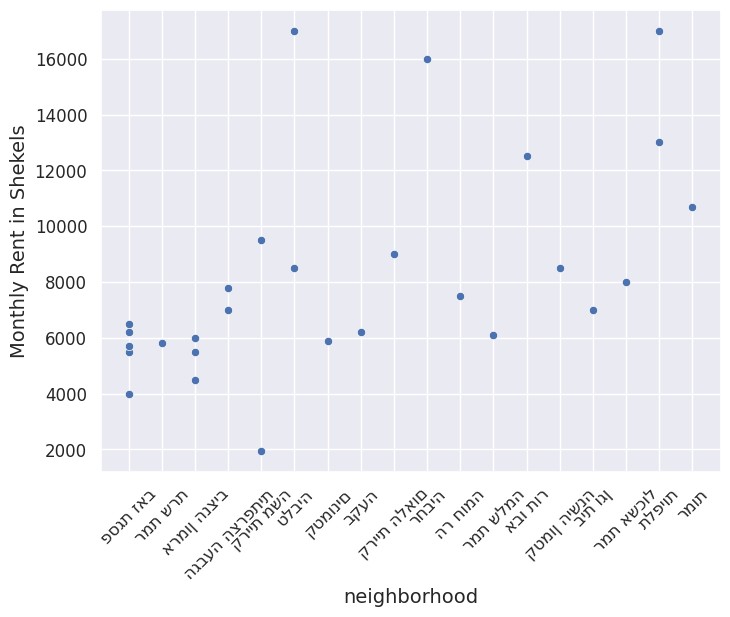

In [58]:
plt.figure(figsize=(8,6)) # size of plot
sns.scatterplot(x='neighborhood', y='monthlyRate', data=part2_df_areaAbove_100) #making scatterplot
plt.xlabel("neighborhood") # naming x axis
plt.ylabel("Monthly Rent in Shekels") #naming y axis
plt.xticks(rotation=45)
plt.show()


---
#### Part 2 Question 4 - textual Answer:
*Write your answer here:*

---

looking at the earlier made scatter plots, I saw that around the 100 m^2, there is a wider spreading of the point. I assumed it made sense, since smaller apat. tend to be located in the center of the city, made in the 20's and 30's of the 20's century, and becauese the service they provide is relativly similar (because of size and location) the prices do not tend to variate strongly.
up a certain size of the apt. let's say 100 m^2, apartments tend to be located further away from the city center (Kiryat Yovel, Armon HaNaziv, ect.). if they are located closer to the city center, that's because those are apt. located in luxirious neighbehoods. therefore, we clearly see that in Talabiya, Kiryat Haleom and in Talpiot, the apt are considirebly more expensive then the rest, what makes the variation of monthly rate so much stronger!

## Part 3: Neighborhoods



In [59]:
# @title Part 3 - Function Definitions and DataFrame Creation
def reverse_string(a):
  return a[::-1]


socialrank_df = load_df(SOCIORANK_ID)
neighborhood_ranks = {k: v for k,v in zip(socialrank_df['neighborhood'], socialrank_df['socioEconomicRank'])}

def get_neighborhood_rank(neighborhood):
  if neighborhood in neighborhood_ranks:
    return neighborhood_ranks[neighborhood]
  else:
    return None

# Create the dataframe and remove the outliers we found in the intro part:
part3_df = rent_df_backup_for_exercise.copy()
part3_df = part3_df[part3_df['monthlyRate'] > 0].reset_index(drop=True);
part3_df = part3_df[part3_df['area'] < 800].reset_index(drop=True)
part3_df = part3_df[part3_df['area'] > 10].reset_index(drop=True)
part3_df["neighborhood_flipped"] = part3_df["neighborhood"].apply(reverse_string) # making the neighborhood names readable

We now want to focus on the differences between different neighborhoods in Jerusalem.

**Use only `part3_df` for the coding questions in this part**

 *Use the `"neighborhood_flipped"` column for visualizations as seaborn will flip the order of letters in hebrew.

###**Question 1**
Print the number of unique neighborhoods that appear in the dataset.

In [62]:
print(f"Number of unique neighborhoods: {part3_df['neighborhood'].nunique()}")

Number of unique neighborhoods: 46


###**Question 2**
Visualize the number of listings per neighborhood in a way that will allow you to easily identify those with the highest count.




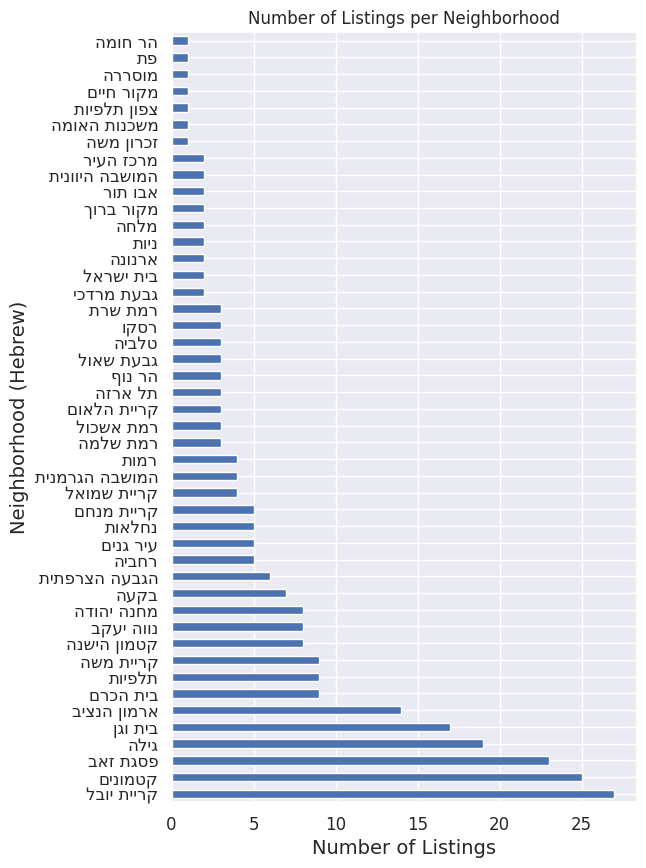

In [71]:
part3_df['neighborhood_flipped'].value_counts().plot(kind='barh', figsize=(6,10))
plt.title("Number of Listings per Neighborhood")
plt.xlabel("Number of Listings")
plt.ylabel("Neighborhood (Hebrew)")
plt.show()


###**Question 3** - Heavy-tailed distributions
Print the number of neighborhoods with less than 5 listings and the fraction of their total number of listings out of the total number of listings. Also print the fraction of listings from the 8 most frequent neighborhoods out of the total number of listings.

In [77]:
# prompt:

num_listings = part3_df.shape[0]
num_neighborhoods = part3_df['neighborhood'].nunique()

# Count listings per neighborhood
neighborhood_counts = part3_df['neighborhood'].value_counts()

# Count neighborhoods with less than 5 listings
low_count_neighborhoods = neighborhood_counts[neighborhood_counts < 5].count()
low_count_listings = neighborhood_counts[neighborhood_counts < 5].sum()

# Count listings from top 8 neighborhoods
top_8_listings = neighborhood_counts.head(8).sum()

# Print results
print(f"Number of neighborhoods with less than 5 listings: {low_count_neighborhoods}")
print(f"Fraction of listings from low-count neighborhoods: {low_count_listings / num_listings:.2f}")
print(f"Fraction of listings from top 8 neighborhoods: {top_8_listings / num_listings:.2f}")


Number of neighborhoods with less than 5 listings: 28
Fraction of listings from low-count neighborhoods: 0.23
Fraction of listings from top 8 neighborhoods: 0.52


Those types of distributions where there are many categories that appear only a few times but together take a large portion of the distribution are called heavy-tailed (or long-tailed) distributions. This is a real issue in many data science applications, since even if we have a large dataset there are still some sub-populations or sub-categories that are not well represented.

###**Question 4**
Create a new filtered dataframe with listings from only the 8 most frequent neighborhoods.

In [82]:
# prompt:

# Get the top 8 neighborhoods
top_8_neighborhoods = part3_df['neighborhood'].value_counts().head(8).index.tolist()

# Filter the dataframe
part3_df_filtered = part3_df[part3_df['neighborhood'].isin(top_8_neighborhoods)]



###**Question 5**
Plot a graph to check whether there are different distributions of monthly rates in the eight neighborhoods. Explain your choice for the visualization and your conclusions.
Note: Make sure that the neighborhoods are ordered in the plot based on their tendency for higher or lower monthly rates.

Hint: Which is a better descriptor of the central tendency of monthly rates when the distributions are skewed?

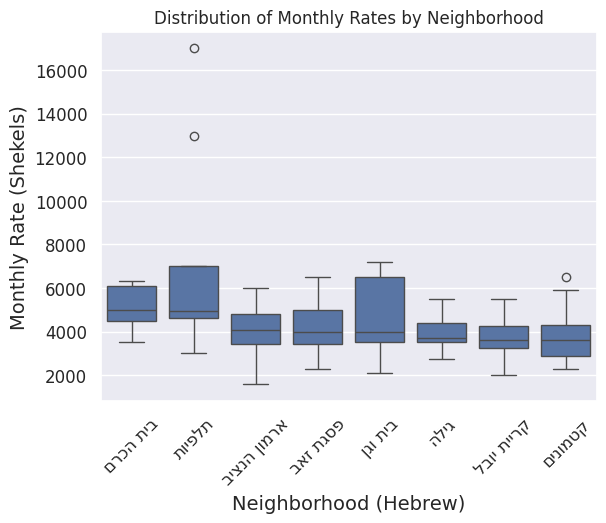

In [90]:
# Calculate the median monthly rate for each neighborhood
median_rates = part3_df_filtered.groupby('neighborhood_flipped')['monthlyRate'].median().sort_values(ascending=False)

# Create a boxplot with neighborhoods ordered by median monthly rate
sns.boxplot(x='neighborhood_flipped', y='monthlyRate', data=part3_df_filtered, order=median_rates.index)
plt.figsize= (12,6)
plt.title('Distribution of Monthly Rates by Neighborhood')
plt.xlabel('Neighborhood (Hebrew)')
plt.ylabel('Monthly Rate (Shekels)')
plt.xticks(rotation=45)
plt.show()


---
#### Part 3 Question 5 - textual Answer:
*Write your answer here:*

---

I've used the Boxplot, for it shows key elements in the different distributions of the different neighborhoods, and by that shows us how different the distribution is between nieghborhoods.my conclusion is that the most expensive, on average, are Beit HaKerem and Talpiyot, the least expensive are Gilo, Kiryat HaYovel and Katamonim, the most spreadout distribution is in Bait VaGan and the least spead out is in Gilo. Talpiyot has strong outliars which are very expensive, can be explaind by the size as we saw before, with the preximity to luxuriush neighbrhoods such as Talabiya and HaMoshava Hagermanit/Hayevanit.

### **Question 6**
Now that we compared the different distributions of monthly rates betwen neighborhoods, we can check whether we can explain some of the differences using our common-sense and the data we already have.
For example, perhaps different neighborhoods have different distributions of apartment sizes?

Think of a new variable that will allow you to check the relationship between neighborhoods and prices fairly, factoring different apartment sizes out of the equation. Save this measure into the dataframe and create a new visualization to answer the question.


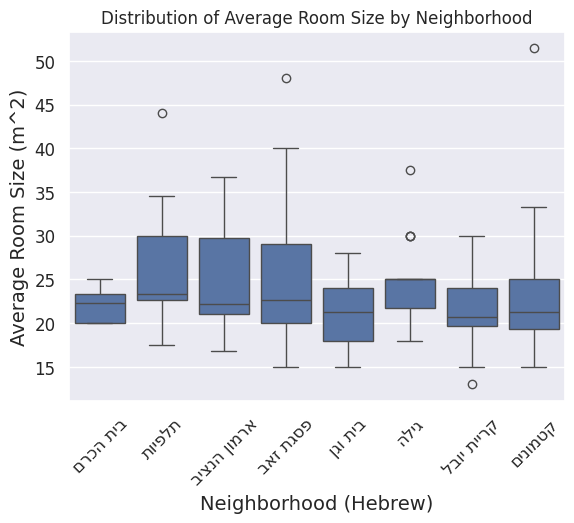

In [96]:
#create average room size column

part3_df_filtered['averageRoomSize'] = part3_df_filtered['area'] / part3_df_filtered['rooms']

# Create a boxplot with neighborhoods ordered by median average room size
sns.boxplot(x='neighborhood_flipped', y='averageRoomSize', data=part3_df_filtered, order=median_rates.index)
plt.title('Distribution of Average Room Size by Neighborhood')
plt.xlabel('Neighborhood (Hebrew)')
plt.ylabel('Average Room Size (m^2)')
plt.xticks(rotation=45)
plt.show()



---
#### Part 3 Question 6 - textual Answer:
*Write your answer here:*


generally speaking, where we see dense distribution of monthly we'll see a dense distribution of room size, and where we see spreadout distributions in monthly rate, we'll also see a spread out distribution of room size.  we also see that in two neighborhoods, Armon Hanaziv and Pisgat Zeev, this trend doesn't seem to exist. the trend might suggest that the monthly rate is heavily effected by the room size, at least in the 8 most frequent listings. the two outliars fom the trend,  Armon Hanaziv and Pisgat Zeev, might suggest there are other fuctors to the variation in monthly rent this explanation cannot take into account.


Given the conclusions from the previous steps, we may think that the apartment's neighborhood gives us additional information about the expected monthly rate. But the sample size for most neighborhoods is rather small. So let's examine another way to utilize the location information. Luckily, we also have data about the socio-economic rank of most neighborhoods (between 1 and 10).

### Question 7 - **bonus**
Use again the full dataset (without filtering by neighborhood).

Create an aggregated dataframe where every record represents a neighborhood, with columns for:
1. neighborhood name
2. flipped neighborhood name
3. The number of listings in a neighborhood
4. The median monthly rate for listings in this neighborhood.

Add a column with the neighborhood socio-economic rank to the dataframe (you can use the provided `get_neighborhood_rank` function that takes as an input a neighborhood name and returns its socio-economic rank.) Use this dataframe to visualize the association between socio-economic rank and pricing for all neighborhoods with at least 5 listings. What is you conclusion?

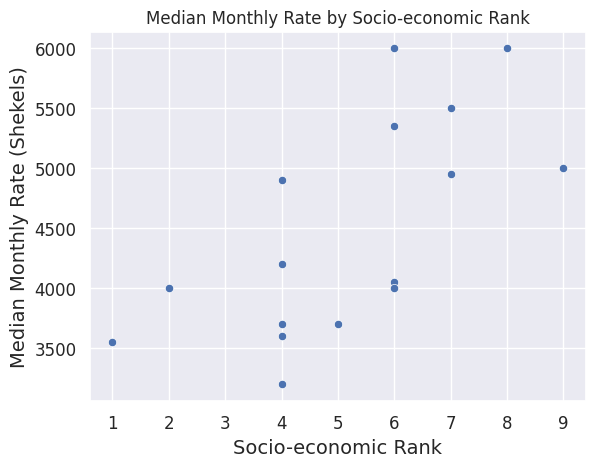

In [130]:
# Create an aggregated dataframe
aggregated_df = part3_df.groupby('neighborhood').agg(
    num_listings=('neighborhood', 'count'),
    median_rate=('monthlyRate', 'median')
).reset_index()

# Add the socio-economic rank
aggregated_df['socio_economic_rank'] = aggregated_df['neighborhood'].apply(get_neighborhood_rank)

# Filter neighborhoods with at least 5 listings
filtered_df = aggregated_df[aggregated_df['num_listings'] >= 5]

# Create a scatter plot
sns.scatterplot(x='socio_economic_rank', y='median_rate', data=filtered_df)
plt.title('Median Monthly Rate by Socio-economic Rank')
plt.xlabel('Socio-economic Rank')
plt.ylabel('Median Monthly Rate (Shekels)')
plt.show()


---
#### Part 3 Question 7 - textual Answer:

---

we can find some correlation between socioecnomic rank and monthly rate, but it is not so linear or monotonous. I assume it is because of the variation of room size as seen before, and number of rooms. small families tend to take smaller apartments with less rooms, so they'll pay less, even in a high ranked socioeconomic neighborhood.

## Part 4: Are private houses more expensive than apartments?

In [97]:
# @title Part 4 - Create a DataFrame and remove outliers for Part 4
part4_df = rent_df_backup_for_exercise.copy()
part4_df = part4_df[part4_df['monthlyRate'] > 0].reset_index(drop=True);
part4_df = part4_df[part4_df['area'] < 800].reset_index(drop=True)
part4_df = part4_df[part4_df['area'] > 10].reset_index(drop=True)

Finally, we want to check if listings in private houses tend to be more expensive than apartments in a building.

**Use only `part4_df` for the coding questions in this part**

### **Question 1**
The current dataset doesn't include a variable that describes whether a listing is in a building or a private house but this can be inferred from the existing variables. Create a new column named "is_a_house" with value of `True` if a listing is in the first (or zero) floor in a building with only one floor. Print the number of private houses and print the descriptions of three random listings with 'is_a_house' equal to `True`.

In [114]:
# prompt:

import pandas as pd
import numpy as np

# Create a new column named "is_a_house"
part4_df['is_a_house'] = (part4_df['floor'] == 0) & (part4_df['numFloors'] == 1)

# Print the number of private houses
num_houses = part4_df['is_a_house'].sum()
print(f"Number of private houses: {num_houses}")

# Print the descriptions of three random listings with 'is_a_house' equal to True
random_house_indices = np.random.choice(part4_df[part4_df['is_a_house']==True].index, size=3, replace=False)
for i in random_house_indices:
    print(f"Description of listing {i}: {part4_df.loc[i, 'description']}")


Number of private houses: 7
Description of listing 67: בס’ד דירה בביניין ישן שעברה שיפוץ, מיטבח חדש,מערכת חשמל חדשה, שירותים שופצו
Description of listing 45: הכי טוב לשלוח הודעה בווטסאפ
Description of listing 71: דירת 2 חדרים חמודה בשכונת מלחה הישנה.  מרוהטת קומפלט (ארון, ספה, טלוויזיה, מקרר, מכונת כביסה, שולחן אוכל, מיטה). יש חנייה בשפע.  מיקום מעולה- מרחק הליכה 5 דקות מקניון מלחה, תחבורה ציבורית מתחת לבית לכל מקום, יציאה לבגין. ללא אפשרות לבעלי חיים.  ללא תיווך. לא מתאים לזוג עם לילדים  מתאים לצעירים / סטודנטים


### **Question 2**
Create a visualization that compares the **average** monthly rates in houses vs. apartments. Which are more expensive on average?

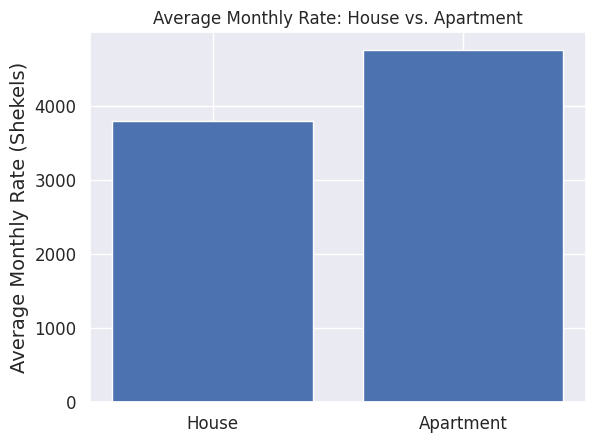

In [115]:
# Calculate the average monthly rate for houses and apartments
avg_rate_house = part4_df[part4_df['is_a_house']]['monthlyRate'].mean()
avg_rate_apartment = part4_df[~part4_df['is_a_house']]['monthlyRate'].mean()

# Create a bar chart to compare average rates
plt.bar(['House', 'Apartment'], [avg_rate_house, avg_rate_apartment])
plt.title('Average Monthly Rate: House vs. Apartment')
plt.ylabel('Average Monthly Rate (Shekels)')
plt.show()


---
#### Part 4 Question 2 - textual Answer:
*Write your answer here:*

---

counterintuitvly, the apt are more expensive than houses. but one needs to take into account that there is greater variation of prices in apt, because apt has more than 250 obs, while houses have only 7.

###**Question 3**  
Now, let's look at the data in a higher resolution. Create a visualization that compares the average monthly rates of houses vs. apartments separetly for any number of rooms. Do the results align with the results from the previous question?

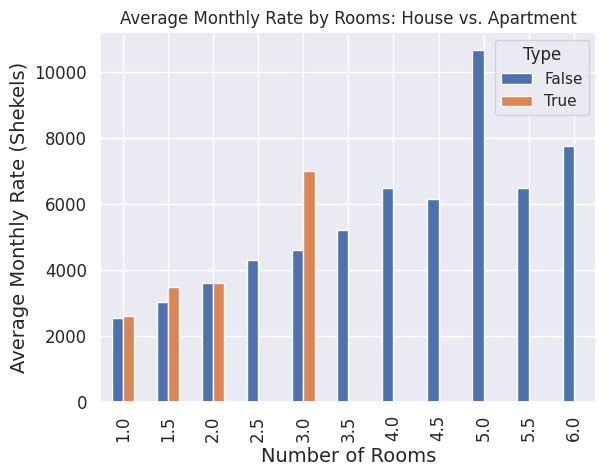

In [123]:
# prompt:

import matplotlib.pyplot as plt
# Calculate the average monthly rate for houses and apartments for each number of rooms
avg_rates_by_rooms = part4_df.groupby(['rooms', 'is_a_house'])['monthlyRate'].mean().unstack()

# Create a line chart to compare average rates for each number of rooms
avg_rates_by_rooms.plot(kind='bar')
plt.title('Average Monthly Rate by Rooms: House vs. Apartment')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Monthly Rate (Shekels)')
plt.legend(title='Type')
plt.show()



---
#### Part 4 Question 3 - textual Answer:
*Write your answer here:*

---

now, we can see that when apt and houses have the same number of rooms, the average rate isalmost the same (slightly higher in houses) for 1,1.5 and 2 rooms, and that for 3 rooms, the average rate of houses signficently higher than the rate of apt.
this correlate with our intuition: houses are more expensive than apt., and with our previous assumption/coclusion: number of rooms effects the monthly rate, along side with the roomsize.

### **Question 4**
Dan saw those visualizations and suggested that the trend in **question 2** is due to the fact that apartments in this dataset have larger maximal number of rooms than houses.

Create a new visualization similar to **question 2**, but consider only apartment listings with a number of rooms less or equal to the maximal number of rooms for a private house listing. Does the result now align with the trend in **question 3**? If not, is the discrapancy smaller than before?

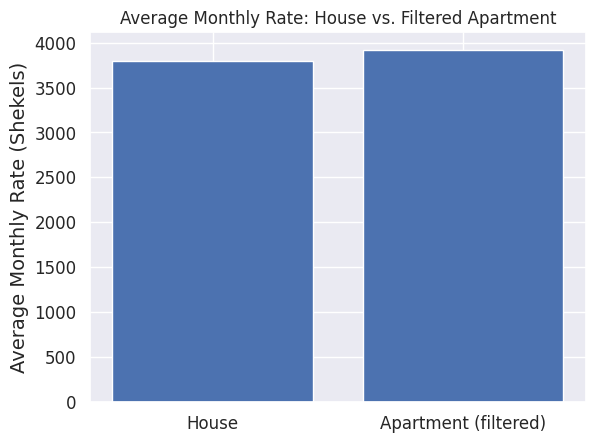

In [124]:
# Find the maximum number of rooms in a house
max_rooms_house = part4_df[part4_df['is_a_house']]['rooms'].max()

# Filter apartment listings to include only those with number of rooms less or equal to max_rooms_house
filtered_apartments = part4_df[~part4_df['is_a_house']][part4_df[~part4_df['is_a_house']]['rooms'] <= max_rooms_house]

# Calculate the average monthly rate for houses and filtered apartments
avg_rate_house = part4_df[part4_df['is_a_house']]['monthlyRate'].mean()
avg_rate_filtered_apartment = filtered_apartments['monthlyRate'].mean()

# Create a bar chart to compare average rates
plt.bar(['House', 'Apartment (filtered)'], [avg_rate_house, avg_rate_filtered_apartment])
plt.title('Average Monthly Rate: House vs. Filtered Apartment')
plt.ylabel('Average Monthly Rate (Shekels)')
plt.show()


---
#### Part 4 Question 4 - textual Answer:
*Write your answer here:*

---
the results do not align with the trend in Q3. apt, still like in the trend in Q2, are more expensive, though the gap narrowed down. I assume that we can narrow it down even more by ommiting apt. with 2.5 rooms, for there are no houses with 2.5 rooms. that inflates the mean of apt for the kind of comparison we'd like to make.

###**Question 5**
Create a visualization that compares the proportion of listings with every value of "number of rooms" in each of the two groups (is_a_house == True and is_a_house == False). How can the results here explain the discrapancy between the results of **question 2** and **question 3**? (Hint: recall the UC Berkeley admission rates example from the first lecture)

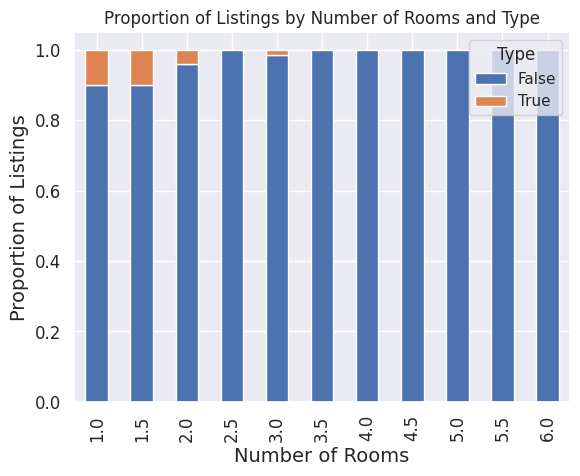

In [125]:
# Create a stacked bar chart to compare the proportion of listings with every value of "number of rooms" in each of the two groups (is_a_house == True and is_a_house == False)
part4_df.groupby('rooms')['is_a_house'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.title('Proportion of Listings by Number of Rooms and Type')
plt.xlabel('Number of Rooms')
plt.ylabel('Proportion of Listings')
plt.legend(title='Type')
plt.show()



---
#### Part 4 Question 5 - textual Answer:
*Write your answer here:*

---

as we saw in the results of Q3, hpuses with 1,1.5 and 2 rooms have very similar monthly rate to apartments, and only the one 3 rooms house has a higher monthly rate to that of the average 3 rooms apartment. in this result, we see taht houses with 1,1.5 and 2  room are much more frequent than 3 rooms houses (by 6:1), what deflates the mean segnificently!

I'd argue we simply do not have enough data here about houses to rightly infer conclusion. it can be treated by aquiring more observations of houses.